__Goal__: of this notebook is to have a glimpse on how easy it is to play with neural networks with Pytorch and illustrate the expressive power and versatility of neural networks:
- We first go through their discriminative power (i.e. classification) on the very classical MNIST data-set. In particular we see how to
    - Define a neural model as a torch.nn.Module.
    - Have a glimpse at convolutional layers, activations etc...
    - Use DataLoader and Data-Augmentation and the intimate link with Stochastic Gradient Descent.
    - How to train the model with optimizers.
    - Perform inference!

- Then we explore neural network representation with fun application like style transfer.
    - Load a pre-trained model.
    - What the model has learnt at each layer.
    - How to define the style transfer problem.
    - Play with it!

- If we have time we go over auto-encoder to explore the 'latent space' of these models.



# 1) First Part: Discriminative Network (classification) on MNIST

__Load the MNIST dataset__

In [128]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision  # for the datasets.
import torchvision.transforms as transforms

# TODO: give the nice references...


# Which transformations to apply to each data point when sampling data point.
# Here simply transform the data-point into a tensor and normalize it.
# A tensor is just a multidimensional matrix!
# torch.tensor is 'equivalent' to np.array
transform = transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                                           ])


mnist_train = torchvision.datasets.MNIST('data/', train=True, transform=transform,
                                         target_transform=None, download=True)
mnist_test = torchvision.datasets.MNIST('data/', train=False, transform=transform,
                                        target_transform=None, download=True)


batch_size_train = 64  # often a power or 2.  
data_loader_train = torch.utils.data.DataLoader(mnist_train,
                                                batch_size=batch_size_train,
                                                shuffle=True)

__Define the Model__

In [42]:
import torch.nn.functional as F

# This is the very generic structure for neural models.
# nn.Conv2d(nbr_input_channel, nbr_output_channel, size_kernel)
# Be careful of the dimension for the First Linear layer (= fully-connected).
class LeNet5(nn.Module):
    def __init__(self):
        # This
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, (5, 5), padding=2)
        self.conv2 = nn.Conv2d(4, 16, (5, 5))
        self.lin1 = nn.Linear(16*5*5, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)
        self.name = 'LeNet5'

    def forward(self, x):
        # simply define the forward pass.
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = F.relu(F.max_pool2d(self.conv2(x), (2, 2)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        # Note that we are outputing 
        return x

__Train the Model__


In [11]:
import torch.optim as optim

model = LeNet5()
model.train()
nbr_epoch = 5  # Number of time we visit the full data set. Up to you and your test loss

# Choose on which device to store the tensor (i.e. the tensor of the weights)
# Here it does not apply, you train things of cpu, but it is just to observe how easy it is with pytorch
# to adapt to the computer infrastructure.
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Define the loss!
criterion = nn.CrossEntropyLoss()  # You can choose many others!
# Same as nn.NLLLoss() but this one takes the logsoftmaxes, not the logit...

# Choose your optimizer and parameters!
# usually there are some guidelines on how to choose the hyper-parameters. Or CV...
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=momentum)

for idx_epoch in range(nbr_epoch):
    counter = 0
    for batch_idx, (data, target) in enumerate(data_loader_train):
        # set the data to the right device
        data = data.to(device)
        target = target.to(device)
        # forget the previous gradient.
        optimizer.zero_grad()
        logit = model(data)
        loss = criterion(logit, target)
        # compute the gradients!!
        loss.backward()
        # Essentially do gradient descent, i.e. weight_{t+1} = weight_t - lr* gradient...
        optimizer.step()
        counter += 1
        if counter % 100 == 0:
            print('batch {} at epoch {} with loss {}'.format(counter,
                                                             idx_epoch,
                                                             loss.item()))
    # save the model!
    # TODO: check that the folder mnist_models/ exists!
    torch.save(model.state_dict(), 'mnist_models/' + '_epoch_' + str(idx_epoch))

batch 100 at epoch 0 with loss 0.6248852014541626
batch 200 at epoch 0 with loss 0.1413070410490036
batch 300 at epoch 0 with loss 0.3108483552932739
batch 400 at epoch 0 with loss 0.4072777032852173
batch 500 at epoch 0 with loss 0.08416639268398285
batch 600 at epoch 0 with loss 0.06290303170681
batch 700 at epoch 0 with loss 0.08653341978788376
batch 800 at epoch 0 with loss 0.1818205714225769
batch 900 at epoch 0 with loss 0.15103690326213837
batch 100 at epoch 1 with loss 0.06533507257699966
batch 200 at epoch 1 with loss 0.025923186913132668
batch 300 at epoch 1 with loss 0.23665398359298706
batch 400 at epoch 1 with loss 0.004572468344122171
batch 500 at epoch 1 with loss 0.019182777032256126
batch 600 at epoch 1 with loss 0.22671976685523987
batch 700 at epoch 1 with loss 0.032077498733997345
batch 800 at epoch 1 with loss 0.0934470146894455
batch 900 at epoch 1 with loss 0.09983570873737335
batch 100 at epoch 2 with loss 0.12231746315956116
batch 200 at epoch 2 with loss 0.007

In [ ]:
__Evaluate the model__

In [24]:
# accuracy on test of the big network
data_loader_test = torch.utils.data.DataLoader(mnist_test,
                                               batch_size=1,
                                               shuffle=True)

def accuracy(model, data_loader_test, nbr=1000):
    pos = 0
    count = 0
    for data, target in data_loader_test:
        data = data.to(device)
        target = target.to(device)
        assert target.shape[0] == 1
        if torch.argmax(model(data).squeeze()).item() == target.item():
            pos += 1
        count += 1
        if count > nbr:
            break
    accuracy = pos/count
    return(accuracy)

for idx in range(nbr_epoch):
    PATH = 'mnist_models/_epoch_{}'.format(idx)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()  # Do it for principle..
    acc = accuracy(model, data_loader_test)
    print('test accuracy is {} at epoch {}'.format(acc, idx))

test accuracy is 0.965034965034965 at epoch 0
test accuracy is 0.9790209790209791 at epoch 1
test accuracy is 0.98001998001998 at epoch 2
test accuracy is 0.991008991008991 at epoch 3
test accuracy is 0.989010989010989 at epoch 4


__How to Data Augmentation in Two lines:__ It is simply small transformation of the images that do not modify the label. For instance
- Add some random pixel-wise noise
- flip the image
- translate the pixel etc..

There is a very large variety of possible data-augmentation. Can depend on the data-set. Can implicitely redefine the unerdlying distribution. Adversarial Data-Augmentation etc etc ...

In [45]:
transform = torchvision.transforms.Compose([
                                            transforms.RandomHorizontalFlip(0.5),
                                            transforms.RandomAffine(degrees=10,
                                                                    translate=(0.1, 0.1)),
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize(
                                            (0.1307,), (0.3081,))
                                           ])

__How to Randomly Initialize the Parameters:__ Because so far we have not specified what we wanted the initial weights to be!!

In [46]:
import numpy as np

# There are many way to define randomness on the initialization of the weights.
def init_weights(m, type_ini='uniform'):
    '''
    Initialization of neural net.
    '''
    assert type_ini in ['uniform', 'gaussian', 'general']
    # for every Linear layer in a model..
    if type(m) == nn.Linear:
        if type_ini == 'uniform':
            m.weight.data.uniform_(0.0, 1.0)
            m.bias.data.fill_(0)
        elif type_ini == 'general':
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)
        elif type_ini == 'gaussian':
            y = m.in_features
            # m.weight.data shoud be taken from a normal distribution
            m.weight.data.normal_(0.0, 1/np.sqrt(y))
            # m.bias.data should be 0
            m.bias.data.fill_(0)
            
# TODO: make an example
model.apply(lambda m: init_weights(m, type_ini='general'))

LeNet5(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=400, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (lin3): Linear(in_features=84, out_features=10, bias=True)
)

# Second Part: Style Transfert

Idea: Write $f_{\theta}$ a trained neural network with parameters $\theta$. And now consider two images: image_content and image_style. We want to change the style of image_content to the style of image_style while keeping the structure of image_content.

__One important fact__: Layers of convolutional neural networks encode different information of an image. You should think each layers at providing a different representation of the image. The first layers encode detailed information (i.e. style) because the networks has not yet mixed up local information. The last layers encode the content.

__Method__: Take a random image $x$ a ask simultaneously that 
 - The deep layers of x via $f_{\theta}$ matches to the deep layers of image_content : i.e. force $x$ to have the content of image_content.
 - The first layers of x via $f_{\theta}$ matches to the first layers of image_content : i.e. force $x$ to have the style of image_style.
 
__Note__: There is slightly more than that, with the Gram-Matrix stuff...
 
__Technical Aspect__: Optimization is over the input of the neural network, not on its weigths!!

__Goal__: Neural Networks are not just good at classifying, they also provide rich representations of data which can be usefull in a variety of contexts.

__Reference__: 
- Gatys et al. (2015). $\textit{Image Style Transfer Using Convolutional Neural Networks}.$
- https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [57]:
import torchvision.models as models

# Defining an already trained Network and how to output the content layers and style layers.
# Note that when redefining a nn.Module there is always the __init__() and forward() methods!
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # load the vgg model's features
        self.vgg = models.vgg19(pretrained=True).features
    
    def get_content_activations(self, x: torch.Tensor) -> torch.Tensor:
        """
            Extracts the features for the content loss from the block4_conv2 of VGG19
            Args:
                x: torch.Tensor - input image we want to extract the features of
            Returns:
                features: torch.Tensor - the activation maps of the block4_conv2 layer
        """
        features = self.vgg[:23](x)
        return features
    
    # Remark: specifying the type of the input and output is not necessary but it is a nice
    # indicator for readability.
    def get_style_activations(self, x: torch.Tensor) -> torch.Tensor:
        """
            Extracts the features for the style loss from the block1_conv1, 
                block2_conv1, block3_conv1, block4_conv1, block5_conv1 of VGG19
            Args:
                x: torch.Tensor - input image we want to extract the features of
            Returns:
                features: list - the list of activation maps of the block1_conv1, 
                    block2_conv1, block3_conv1, block4_conv1, block5_conv1 layers
        """
        features = [self.vgg[:4](x)] + [self.vgg[:7](x)] + [self.vgg[:12](x)] + [self.vgg[:21](x)] + [self.vgg[:30](x)] 
        return features
    
    def forward(self, x):
        return self.vgg(x)


# itinialize a model
vgg = VGG()
# We are not going to optimize over the weights of the network
for param in vgg.parameters():
    param.requires_grad = False

Load a content and style image

In [69]:
from PIL import Image
# Remark: for non-pedagological purposes, this is a very bad practice to import module not at the beginning
# of the script.

imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_image = image_loader('mnist_models/content.jpg')
style_image = image_loader('mnist_models/style.jpg')

# TODO: solve this issue...
# assert style_image.size() == content_image.size(), \
#     "we need to import style and content images of the same size"

Get the content and style layers from the network model of image_content and image_style

In [133]:
# get the content activations of the content image and detach them from the graph
content_activations = vgg.get_content_activations(content_image).detach()

# unroll the content activations
content_activations = content_activations.view(512, -1)

def gram(tensor):
    """
        Constructs the Gramian matrix out of the tensor
    """
    return torch.mm(tensor, tensor.t())

# get the style activations of the style image
style_activations = vgg.get_style_activations(style_image)

# for every layer in the style activations
for i in range(len(style_activations)):

    # unroll the activations and detach them from the graph
    style_activations[i] = style_activations[i].squeeze().view(style_activations[i].shape[1], -1).detach()

# calculate the gram matrices of the style image
style_grams = [gram(style_activations[i]) for i in range(len(style_activations))]


__Define losses__

In [134]:
def content_loss(noise: torch.Tensor, image: torch.Tensor) -> float:
    return 1/2. * torch.sum(torch.pow(noise - image, 2))


def gram_loss(noise_img_gram, style_img_gram, N, M):
    return torch.sum(torch.pow(noise_img_gram - style_img_gram, 2)).div((np.power(N*M*2, 2, dtype=np.float64)))


__Optimize from random noise to get a style transfer image__

In [135]:
# generate the Gaussian noise
x = torch.randn(1, 3, imsize, imsize, device=device, requires_grad=True)

# define the adam optimizer
# pass the feature map pixels to the optimizer as parameters
adam = optim.Adam(params=[x], lr=0.01, betas=(0.9, 0.999))
content_weight = 1
style_weight = 500
num_iter = 1000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 0 iterations


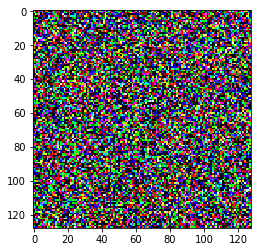

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 2 iterations


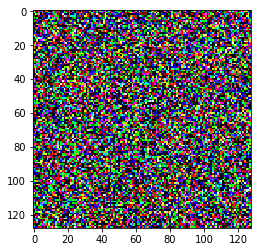

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 4 iterations


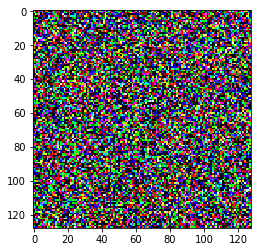

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 6 iterations


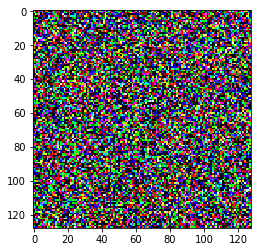

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 8 iterations


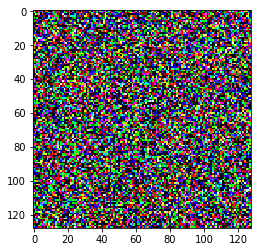

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 10 iterations


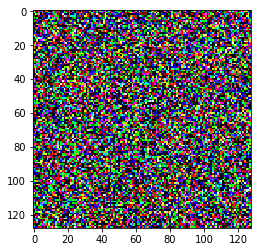

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 12 iterations


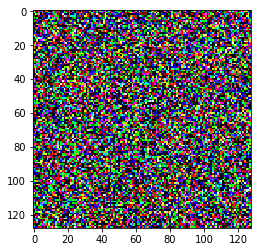

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 14 iterations


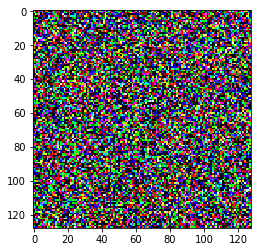

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 16 iterations


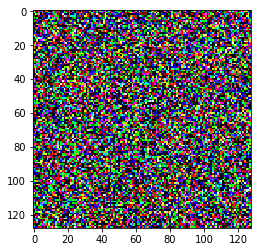

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 18 iterations


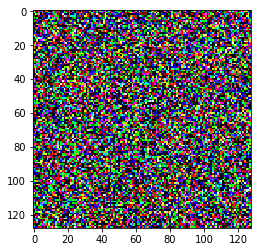

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 20 iterations


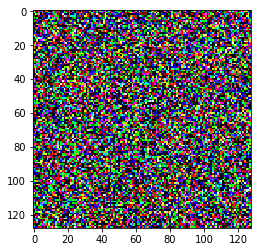

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 22 iterations


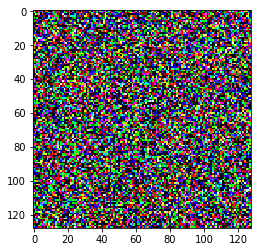

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 24 iterations


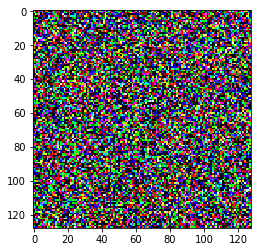

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 26 iterations


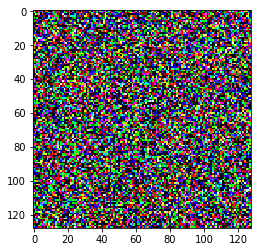

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 28 iterations


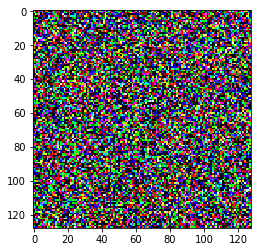

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 30 iterations


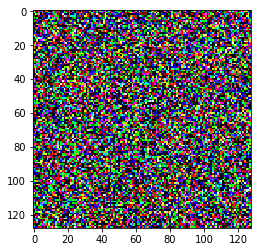

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 32 iterations


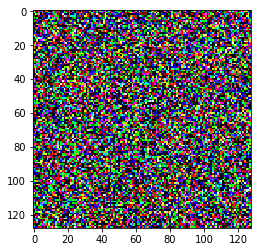

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 34 iterations


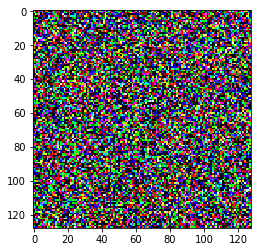

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 36 iterations


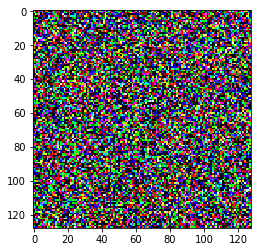

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 38 iterations


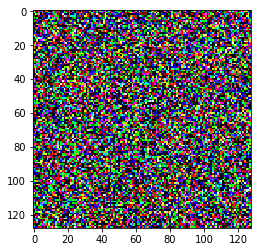

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 40 iterations


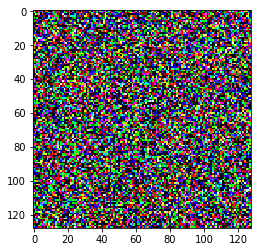

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 42 iterations


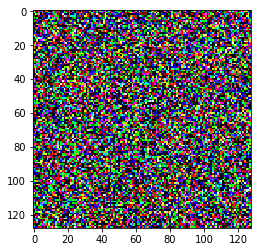

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 44 iterations


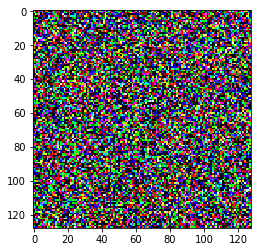

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 46 iterations


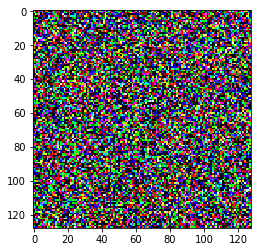

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 48 iterations


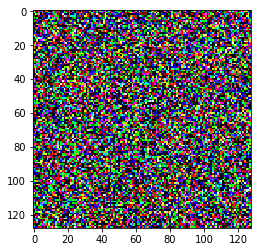

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 50 iterations


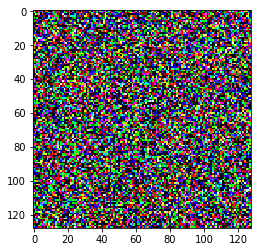

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 52 iterations


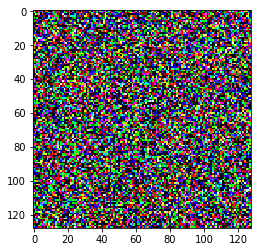

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with 54 iterations


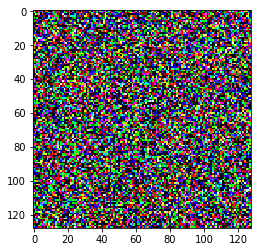

KeyboardInterrupt: 

In [136]:
import matplotlib.pyplot as plt

# run the iteration
for iteration in range(num_iter):

    # zero the gradient
    adam.zero_grad()

    # get the content activations of the Gaussian noise
    noise_content_activations = vgg.get_content_activations(noise)

    # unroll the feature maps of the noise
    noise_content_activations = noise_content_activations.view(512, -1)

    # calculate the content loss
    content_loss_ = content_loss(noise_content_activations, content_activations)

    # get the style activations of the noise image
    noise_style_activations = vgg.get_style_activations(noise)

    # for every layer
    for i in range(len(noise_style_activations)):

        # unroll the the noise style activations
        noise_style_activations[i] = noise_style_activations[i].squeeze().view(noise_style_activations[i].shape[1], -1)

    # calculate the noise gram matrices
    noise_grams = [gram(noise_style_activations[i]) for i in range(len(noise_style_activations))]

    # calculate the total weighted style loss
    style_loss = 0
    for i in range(len(style_activations)):
        N, M = noise_style_activations[i].shape[0], noise_style_activations[i].shape[1]
        style_loss += (gram_loss(noise_grams[i], style_grams[i], N, M) / 5.)

    # put the style loss on device
    style_loss = style_loss.to(device)

    # calculate the total variation loss
    # variation_loss = total_variation_loss(noise).to(device)

    # weight the final losses and add them together
    total_loss = content_weight * content_loss_ + style_weight * style_loss # + variation_weight * variation_loss
    
    # backprop
    total_loss.backward()

    # update parameters
    adam.step()
    
    if iteration % 50 == 0:
        print('Done with {} iterations'.format(iteration))
        plt.figure(1)
        plt.imshow(x.detach().squeeze().view((128, 128, 3)).numpy())
        plt.show()
        plt.close()

In [ ]:
# Plot the final result
plt.figure(1)
plt.imshow(x.detach().squeeze().view((128, 128, 3)).numpy())
plt.show()

# Third Part: Auto-Encoders and play with latent-space representation for generating GIFS.